# Mitochondrial trafficking simulation script + plotting


In [1]:
from __future__ import division
import pylab as plt
from numpy import random,argwhere,argmax,linspace,logspace,var,mean,tile,dot
import copy
from numpy.random import randint
from scipy.stats import norm,nbinom
from scipy import sparse
import numpy as np
%matplotlib inline
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
import scipy.io as sio
from collections import Counter
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import time
import os.path
import pickle

In [2]:
from morphopy.computation import file_manager as fm
from morphopy.neurontree import NeuronTree as nt
import pandas as pd
import networkx as nx

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# My modules
import modmorf
import modsim
import modout
import modplot

In [5]:
script_dir = os. getcwd() # get current scipt directory

In [6]:
def simplifyGraph(G):
    ''' Loop over the graph until all nodes of degree 2 have been removed and their incident edges fused '''

    g = G.copy()

    while any(degree==2 for _, degree in g.degree):

        g0 = g.copy() #<- simply changing g itself would cause error `dictionary changed size during iteration` 
        for node, degree in g.degree():
            if degree==2:

                if g.is_directed(): #<-for directed graphs
                    a0,b0 = list(g0.in_edges(node))[0]
                    a1,b1 = list(g0.out_edges(node))[0]

                else:
                    edges = g0.edges(node)
                    edges = list(edges.__iter__())
                    a0,b0 = edges[0]
                    a1,b1 = edges[1]

                e0 = a0 if a0!=node else b0
                e1 = a1 if a1!=node else b1

                g0.remove_node(node)
                g0.add_edge(e0, e1)
        g = g0

    return g

## Load Tree and get Tree attributes

In [7]:
morphofile = "tree_10_mm_path.swc" # symmetrical tree with 10 mm distance between soma and endpoints
# tree is already  resampled at 0.2 um internode distanece

Nt = fm.load_swc_file(script_dir+'//morphologies//'+morphofile)

In [8]:
internode = 0.2 # (distance in um)
#Axon = Nt.get_axonal_tree().resample_tree(dist=internode) # get axonal tree and resample internode distance
Axon = Nt.get_axonal_tree() #  get axonal tree only (still includes the single soma node)
DirA = Axon.get_adjacency_matrix(weight=None) # adjacency matrix of axonal tree (directed matrix - only children connections)
A = DirA + np.transpose(DirA)                 # adjacency matrix with children and parent connections

In [9]:
## loading pre-existing axon object (already resampled)
'''
file_axon = open('morphologies/AA0618_Resampled_Axon_0.2.obj', 'rb')
morphofile = 'AA0618_Resampled_Axon_0.2.obj'
Axon = pickle.load(file_axon)
DirA = Axon.get_adjacency_matrix(weight=None) # adjacency matrix of resampled axonal tree (directed matrix - only children connections)
A = DirA + np.transpose(DirA)   
internode = 0.2
'''

"\nfile_axon = open('morphologies/AA0618_Resampled_Axon_0.2.obj', 'rb')\nmorphofile = 'AA0618_Resampled_Axon_0.2.obj'\nAxon = pickle.load(file_axon)\nDirA = Axon.get_adjacency_matrix(weight=None) # adjacency matrix of resampled axonal tree (directed matrix - only children connections)\nA = DirA + np.transpose(DirA)   \ninternode = 0.2\n"

In [10]:
N = modmorf.get_number_of_nodes(A) # number of nodes/positions
print(N)

116656


In [11]:
#Parent and Children only matrices
Parent, Children = modmorf.relations_nodes(A)  # Parent, Children (edges = 1)

In [12]:
##Rename nodes to match adjacency matrix indexes (start node is 0 instead of 1) - the new naming of nodes will be used in all following dicitonaries called

# first, create a dictionary of indices 'mydict' {old ind: new ind} to pass as 'label' argument in rename function
mydict = Axon.get_node_attributes('type') # using any of the functions to bring up a dictionary with current indexing system
for i, key in enumerate(mydict):  # iterates on the keys (ie current indices)  
    mydict[key] = i               # give value 0 to n

Axon.rename_nodes(label=mydict) # rename nodes to match adj matrix indexes

In [13]:
BP = Axon.get_branchpoints() # branchpoints array
EP = Axon.get_tips() # endpoints array

# children of branchpoints array
CBP = []   
for i in range(len(BP)):
    CBP.append((Children[BP[i],:]).indices)
CBP = np.array(CBP)   

NodeType = Axon.get_node_attributes('type') # type of node dictionary - 1 is soma, 2 is axon 

In [14]:
'''
## the Branch order dictionary for each node is too big to hold in memory (too many nodes) - use different method 
#BO = Axon.get_branch_order() # branch order dictionary ## makes kernel crash when tree is too big !!!
#BOposN = Counter(BO.values()) # number of nodes per BOid
#maxBO = len(BOposN)-1 # highest branch order 

'''

'\n## the Branch order dictionary for each node is too big to hold in memory (too many nodes) - use different method \n#BO = Axon.get_branch_order() # branch order dictionary ## makes kernel crash when tree is too big !!!\n#BOposN = Counter(BO.values()) # number of nodes per BOid\n#maxBO = len(BOposN)-1 # highest branch order \n\n'

In [15]:
ChildrenWeighed = modmorf.child_matrix_weighed2(Children, N, BP)  # ChildrenWeighed (edges = 0.5 if following BP, else =1)

In [16]:
Axon.get_segment_length(dist='path_length')

{(0, 16665): 3332.9999999988313,
 (16665, 33330): 3333.220920306804,
 (16665, 83325): 3333.220920306804,
 (33330, 49995): 3333.058636943559,
 (33330, 66660): 3333.0639386411985,
 (83325, 116655): 3333.058636943559,
 (83325, 99990): 3333.0639386411985}

In [17]:
segments_list = list(Axon.get_segment_length().keys()) # branch segments and their length (list)
print(segments_list)

[(0, 16665), (16665, 33330), (16665, 83325), (33330, 49995), (33330, 66660), (83325, 116655), (83325, 99990)]


In [18]:
distfromsoma = Axon.get_path_length()
maxdistfromsoma = max(distfromsoma.values())
print(maxdistfromsoma)

9999.284858945526


In [19]:
xycoordinates = modmorf.xy_coordinates(Axon) # dict of xy corrdinates per node/position

In [20]:
totallength = sum((Axon.get_segment_length(dist='path_length')).values()) # total length of tree (all branches added)
print(totallength)

23331.68699178195


In [21]:
### wrote BO_dict manually for "tree_10_mm_path.swc" because couln't figure out how to code 
BO_dict = {(0,16665):0 , (16666,33330):1 , (33331,49995):2 , (49996,66660):2 , (66661,83325):1 , (83326,99990):2 , (99991,116655):2}
maxBO = max(BO_dict.values())


#making BOposN Counter - counter of number of nodes (dict value) per branch order (key)

lengths_dict = {}
for segment, value in BO_dict.items():
    x, y = segment
    difference = (y - x )+1
    if difference in lengths_dict:
        lengths_dict[difference].append(value)
    else:
        lengths_dict[difference] = [value]

print(lengths_dict)

# Sum all the keys that have the same value

BOposN = {}

for value, ids in lengths_dict.items():
    for i in ids:
        if i in BOposN:
            BOposN[i] += value
        else:
            BOposN[i] = value
print(BOposN)

{16666: [0], 16665: [1, 2, 2, 1, 2, 2]}
{0: 16666, 1: 33330, 2: 66660}


## Parameters

In [22]:
genotype = 'wt'  # 'wt' or 'tau' 

timestep = 1 # (second) 1 timestep = 1 second

numtimesteps = 1728000    # number of timsteps per particle run (t)
runs = 1000      #number of mitochondria (R)
snapshot_num = 120 # None #in number of timesteps 

#intialisation paramters
randompos = False
randomstate = True
x0 = 0 if randompos == False else None # x0 is None if randompos is True
s0 = 3 if randomstate == False else None
                           
#states: off = 0, pause = 1, retrograde = 2, anterograde = 3 
statesarray = np.array([0,1,2,3]) 

    #if randomstate = True, choosing steadyinit=False means that steady state (eigenvectors) will be used instead of specified states start probabilities below
steadyinit = True 
states_startprob = [0.25, 0.25, 0.25, 0.25] if steadyinit == False else None 

if genotype == 'wt':
    avg_mob_velocity = 0.7256 # um/s - calculated frrom Jame's data as mobile as avg evlocity of all mobiel timepoints
    adjusted_velocity = ((avg_mob_velocity*timestep)/internode)-1 #(2.628 node/tinestep) (avg_velocity node/timestep -1)

if genotype == 'tau':
    avg_mob_velocity = 0.7247 # um/s - calculated frrom Jame's data as mobile as avg evlocity of all mobiel timepoints
    adjusted_velocity = ((avg_mob_velocity*timestep)/internode)-1 #(2.628 node/tinestep) (avg_velocity node/timestep -1)


In [23]:
## Optimised states transition probabilities parameters 

optiparams = [9.99996458e-01, 1.06270654e-07, 3.43608447e-06, 3.56562148e-04, 2.99893031e-02, 9.69654135e-01, 9.76096825e-05, 
              6.07894140e-01, 1.17602475e-02, 3.80248003e-01, 9.76096825e-05, 6.07894140e-01, 1.17602475e-02, 3.80248003e-01] # v4.1 wt single 

#optiparams = [9.99996458e-01, 9.85860103e-08, 3.44376912e-06, 3.56562148e-04, 4.43401543e-02, 9.55303284e-01, 9.76096825e-05,
              #6.07894140e-01, 2.03938764e-03, 3.89968863e-01, 9.76096825e-05, 6.07894140e-01, 6.94925335e-02, 3.22515717e-01] #v4.1 wt multiple k flipped

    
#optiparams = [9.99993075e-01, 2.45484804e-06, 4.47036806e-06, 6.97478300e-01, 3.02324607e-01, 1.97092888e-04, 4.45601740e-04,
              #6.83873293e-01, 3.09308252e-01, 6.37285335e-03, 4.45601740e-04, 6.83873293e-01, 2.26598180e-01, 8.90829255e-02] # tau

#optiparams = [9.99993075e-01, 4.47036806e-06, 2.45484804e-06, 6.97478300e-01, 1.97092888e-04, 3.02324607e-01, 4.45601740e-04,
              #6.83873293e-01, 6.37285335e-03, 3.09308252e-01, 4.45601740e-04, 6.83873293e-01, 8.90829255e-02, 2.26598180e-01] # tau A/R flip

In [ ]:
'''
## k variations of optiparam ## 
k = 0.97

if k == 0.05:
    optiparams = [9.99996458e-01, 1.77117756e-07, 3.36523737e-06, 3.56562148e-04, 4.99821719e-02, 9.49661266e-01, 9.76096825e-05, 
                  6.07894140e-01, 1.96004125e-02, 3.72407838e-01, 9.76096825e-05, 6.07894140e-01, 1.96004125e-02, 3.72407838e-01]

if k == 0.10:
    optiparams = [9.99996458e-01, 3.54235513e-07, 3.18811961e-06, 3.56562148e-04, 9.99643438e-02, 8.99679094e-01, 9.76096825e-05,
                  6.07894140e-01, 3.92008250e-02, 3.52807425e-01, 9.76096825e-05, 6.07894140e-01, 3.92008250e-02, 3.52807425e-01]

if k == 0.20:
    optiparams = [9.99996458e-01, 7.08471025e-07, 2.83388410e-06, 3.56562148e-04, 1.99928688e-01, 7.99714750e-01, 9.76096825e-05,
                  6.07894140e-01, 7.84016501e-02, 3.13606600e-01, 9.76096825e-05, 6.07894140e-01, 7.84016501e-02, 3.13606600e-01]

if k == 0.30: 
    optiparams = [9.99996458e-01, 1.06270654e-06, 2.47964859e-06, 3.56562148e-04, 2.99893031e-01, 6.99750406e-01, 9.76096825e-05,
                  6.07894140e-01, 1.17602475e-01, 2.74405775e-01, 9.76096825e-05, 6.07894140e-01, 1.17602475e-01, 2.74405775e-01]

if k == 0.40:
    optiparams = [9.99996458e-01, 1.41694205e-06, 2.12541308e-06, 3.56562148e-04, 3.99857375e-01, 5.99786063e-01, 9.76096825e-05,
                  6.07894140e-01, 1.56803300e-01, 2.35204950e-01, 9.76096825e-05, 6.07894140e-01, 1.56803300e-01, 2.35204950e-01]
    
if k == 0.50:
    optiparams = [9.99996458e-01, 1.77117756e-06, 1.77117756e-06, 3.56562148e-04, 4.99821719e-01, 4.99821719e-01, 9.76096825e-05,
                  6.07894140e-01, 1.96004125e-01, 1.96004125e-01, 9.76096825e-05, 6.07894140e-01, 1.96004125e-01, 1.96004125e-01]

if k == 0.60:
    optiparams = [9.99996458e-01, 2.12541308e-06, 1.41694205e-06, 3.56562148e-04, 5.99786063e-01, 3.99857375e-01, 9.76096825e-05,
                  6.07894140e-01, 2.35204950e-01, 1.56803300e-01, 9.76096825e-05, 6.07894140e-01, 2.35204950e-01, 1.56803300e-01]
    
if k == 0.70:
    optiparams = [9.99996458e-01, 2.47964859e-06, 1.06270654e-06, 3.56562148e-04, 6.99750406e-01, 2.99893031e-01, 9.76096825e-05,
                  6.07894140e-01, 2.74405775e-01, 1.17602475e-01, 9.76096825e-05, 6.07894140e-01, 2.74405775e-01, 1.17602475e-01]

if k == 0.80:
    optiparams = [9.99996458e-01, 2.83388410e-06, 7.08471025e-07, 3.56562148e-04, 7.99714750e-01, 1.99928688e-01, 9.76096825e-05,
                  6.07894140e-01, 3.13606600e-01, 7.84016501e-02, 9.76096825e-05, 6.07894140e-01, 3.13606600e-01, 7.84016501e-02]
    
if k == 0.90: 
    optiparams = [9.99996458e-01, 3.18811961e-06, 3.54235513e-07, 3.56562148e-04, 8.99679094e-01, 9.99643438e-02, 9.76096825e-05, 
                  6.07894140e-01, 3.52807425e-01, 3.92008250e-02, 9.76096825e-05, 6.07894140e-01, 3.52807425e-01, 3.92008250e-02]

if k == 0.95: 
    optiparams = [9.99996458e-01, 3.36523737e-06, 1.77117756e-07, 3.56562148e-04, 9.49661266e-01, 4.99821719e-02, 9.76096825e-05, 
                  6.07894140e-01, 3.72407838e-01, 1.96004125e-02, 9.76096825e-05, 6.07894140e-01, 3.72407838e-01, 1.96004125e-02]
    
if k == 0.97: 
    optiparams = [9.99996458e-01, 3.43608447e-06, 1.06270654e-07, 3.56562148e-04, 9.69654135e-01, 2.99893031e-02, 9.76096825e-05,
                  6.07894140e-01, 3.80248003e-01, 1.17602475e-02, 9.76096825e-05, 6.07894140e-01, 3.80248003e-01, 1.17602475e-02]
'''

In [24]:
paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}


In [25]:
##degradation parameters
degr_range_h = [10, 120, 240, 360, 480, 600, 720, 840, 960] #hours 
degr_range = [i * 3600 for i in degr_range_h]
print(degr_range)

[36000, 432000, 864000, 1296000, 1728000, 2160000, 2592000, 3024000, 3456000]


## Steady states and calculations

In [26]:
s0s0, s0s2, s0s3, s1s1, s1s2, s1s3, s2s0, s2s1, s2s2, s2s3, s3s0, s3s1, s3s2, s3s3 = optiparams
    
s0s1 = 0
s1s0 = 0

#build transition probabilities arrays
Tr = np.array([[s0s0, s0s1, s0s2, s0s3], [s1s0, s1s1, s1s2, s1s3], [s2s0, s2s1, s2s2, s2s3], [s3s0, s3s1, s3s2, s3s3]], dtype='float')

In [27]:
eigenvalues, eigenvectors = np.linalg.eig(np.asmatrix(Tr).T)
steady_state_index = np.where(np.isclose(eigenvalues, 1))[0][0]
steady_state_vector = abs(np.real(eigenvectors[:, steady_state_index]))
steady_state_vector = np.asarray(steady_state_vector.ravel())[0]
steady = steady_state_vector/np.sum(steady_state_vector)

print(steady) # steady states
print(sum(steady))

[0.94485821 0.020852   0.00102869 0.0332611 ]
1.0


In [28]:
#scale on-track steady states 
steadysum = steady[1]+steady[2]+steady[3]
scaleP = steady[1]/steadysum
scaleR = steady[2]/steadysum
scaleA = steady[3]/steadysum

In [29]:
#multiply scaled steady states by transition state -> off track
scPO = scaleP*0 
scRO = scaleR*s2s0 
scAO = scaleA*s3s0

#sum those transitions 
sum_sc_transitions = scPO + scRO + scAO

#timestep = 1 second, node interval = 0.2 um, velocity when moving =  0.7256 um/sec
timestep = 1
velocity = 0.7256

#run time 
avg_runtime = timestep/(sum_sc_transitions) #in seconds 


#run length 
avg_runlength = avg_runtime*velocity*(scaleA - scaleR)


print(f"average run length {avg_runlength} um")
print(f"average run time {avg_runtime} sec")
print(f"sum_sc_transitions:{ sum_sc_transitions}")


average run length 6987.66743821448 um
average run time 16474.912405768577 sec
sum_sc_transitions:6.069835003492078e-05


## Simulation

In [ ]:
## Without snapshot (only use if small simulation time)

Xresult, Sresult = modsim.sim_ensemble(Parent,ChildrenWeighed, paramfixed, optiparams, scale=True)  # arrays are 2d where row = 1 run and column = timepoint 


In [30]:
## With snapshot

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)  # arrays are 2d where row = 1 run and column = timepoint 
                            #X[i] is particle/run number i in range(R)   


In [31]:
## Degradation on sapshot Xresult/Sresult (using degradation mean)

XresultDeg, SresultDeg = modsim.degrade(degr_range[8]/snapshot_num, Xresult, Sresult, runs, int(numtimesteps/snapshot_num), timestep)


## Simulations with k variations

In [ ]:
#k = 0.03
optiparams = [9.99996458e-01, 1.06270654e-07, 3.43608447e-06, 3.56562148e-04, 2.99893031e-02, 9.69654135e-01, 9.76096825e-05, 
              6.07894140e-01, 1.17602475e-02, 3.80248003e-01, 9.76096825e-05, 6.07894140e-01, 1.17602475e-02, 3.80248003e-01]

paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_03.npz', Xresult = Xresult, Sresult = Sresult)                         

In [ ]:
# k = 0.10
optiparams = [9.99996458e-01, 3.54235513e-07, 3.18811961e-06, 3.56562148e-04, 9.99643438e-02, 8.99679094e-01, 9.76096825e-05,
              6.07894140e-01, 3.92008250e-02, 3.52807425e-01, 9.76096825e-05, 6.07894140e-01, 3.92008250e-02, 3.52807425e-01]

paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_10.npz', Xresult = Xresult, Sresult = Sresult)   

In [ ]:
#k = 0.20 
optiparams = [9.99996458e-01, 7.08471025e-07, 2.83388410e-06, 3.56562148e-04, 1.99928688e-01, 7.99714750e-01, 9.76096825e-05,
              6.07894140e-01, 7.84016501e-02, 3.13606600e-01, 9.76096825e-05, 6.07894140e-01, 7.84016501e-02, 3.13606600e-01]

paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_20.npz', Xresult = Xresult, Sresult = Sresult)   

In [ ]:
#k = 0.30
optiparams = [9.99996458e-01, 1.06270654e-06, 2.47964859e-06, 3.56562148e-04, 2.99893031e-01, 6.99750406e-01, 9.76096825e-05,
              6.07894140e-01, 1.17602475e-01, 2.74405775e-01, 9.76096825e-05, 6.07894140e-01, 1.17602475e-01, 2.74405775e-01]


paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_30.npz', Xresult = Xresult, Sresult = Sresult)   

In [ ]:
#k = 0.40

optiparams = [9.99996458e-01, 1.41694205e-06, 2.12541308e-06, 3.56562148e-04, 3.99857375e-01, 5.99786063e-01, 9.76096825e-05,
              6.07894140e-01, 1.56803300e-01, 2.35204950e-01, 9.76096825e-05, 6.07894140e-01, 1.56803300e-01, 2.35204950e-01]

paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_40.npz', Xresult = Xresult, Sresult = Sresult)   

In [ ]:
#k = 0.50
optiparams = [9.99996458e-01, 1.77117756e-06, 1.77117756e-06, 3.56562148e-04, 4.99821719e-01, 4.99821719e-01, 9.76096825e-05,
              6.07894140e-01, 1.96004125e-01, 1.96004125e-01, 9.76096825e-05, 6.07894140e-01, 1.96004125e-01, 1.96004125e-01]


paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_50.npz', Xresult = Xresult, Sresult = Sresult)   

In [ ]:
#k = 0.60
optiparams = [9.99996458e-01, 2.12541308e-06, 1.41694205e-06, 3.56562148e-04, 5.99786063e-01, 3.99857375e-01, 9.76096825e-05,
              6.07894140e-01, 2.35204950e-01, 1.56803300e-01, 9.76096825e-05, 6.07894140e-01, 2.35204950e-01, 1.56803300e-01]


paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_60.npz', Xresult = Xresult, Sresult = Sresult)   

In [ ]:
#k = 0.70
optiparams = [9.99996458e-01, 2.47964859e-06, 1.06270654e-06, 3.56562148e-04, 6.99750406e-01, 2.99893031e-01, 9.76096825e-05,
              6.07894140e-01, 2.74405775e-01, 1.17602475e-01, 9.76096825e-05, 6.07894140e-01, 2.74405775e-01, 1.17602475e-01]


paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_70.npz', Xresult = Xresult, Sresult = Sresult)   

In [ ]:
#k = 0.80
optiparams = [9.99996458e-01, 2.83388410e-06, 7.08471025e-07, 3.56562148e-04, 7.99714750e-01, 1.99928688e-01, 9.76096825e-05,
              6.07894140e-01, 3.13606600e-01, 7.84016501e-02, 9.76096825e-05, 6.07894140e-01, 3.13606600e-01, 7.84016501e-02]

paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_80.npz', Xresult = Xresult, Sresult = Sresult)   

In [ ]:
#k = 0.90
optiparams = [9.99996458e-01, 3.18811961e-06, 3.54235513e-07, 3.56562148e-04, 8.99679094e-01, 9.99643438e-02, 9.76096825e-05, 
              6.07894140e-01, 3.52807425e-01, 3.92008250e-02, 9.76096825e-05, 6.07894140e-01, 3.52807425e-01, 3.92008250e-02]

paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_90.npz', Xresult = Xresult, Sresult = Sresult)   

In [ ]:
#k = 0.97
optiparams = [9.99996458e-01, 3.43608447e-06, 1.06270654e-07, 3.56562148e-04, 9.69654135e-01, 2.99893031e-02, 9.76096825e-05,
                  6.07894140e-01, 3.80248003e-01, 1.17602475e-02, 9.76096825e-05, 6.07894140e-01, 3.80248003e-01, 1.17602475e-02]

paramfixed  = {'genotype':genotype, 'numtimesteps': numtimesteps, 'runs': runs, 'snapshot_num': snapshot_num, 'statesarray':statesarray, 'adjusted_velocity':adjusted_velocity, 
               'N': N, 'x0':x0, 's0': s0, 'states_startprob':states_startprob, 'randompos':randompos, 'randomstate':randomstate, 'steadyinit':steadyinit,
              'EP':EP, 'BP':BP, 'CBP':CBP, 'transitions': optiparams, 'morphofile': morphofile, 'nodedist': internode}

Xresult, Sresult = modsim.sim_ensemble_snapshot(Parent,ChildrenWeighed,paramfixed, optiparams, snapshot = snapshot_num, scale=True)
#np.savez(save_dir+'//sim_results_97.npz', Xresult = Xresult, Sresult = Sresult)

## Post simulation processing/plotting

In [32]:
## use this when snapshot was used in simulations! for the sake of easy post simualtion functions: 
numtimesteps_post= int(numtimesteps/snapshot_num)

#numtimesteps_post = numtimesteps # when no snapshot was used

In [33]:
## Functions to compute runtime i.e. time to reach an endpoint once moving. Does not take into account mitohcondira that are already moving
def find_first_occurrence_in_list(arr,mylist):
    mask = np.isin(arr, mylist)
    if np.any(mask):
        return np.argmax(mask) 
    else: 
        return -1

def find_nonzero_occurrence(arr):
    mask = arr != 0   
    if np.any(mask):
        return np.argmax(mask)
    else:
        return -1

def runtimes(array): # 
    runtime = np.empty(runs, dtype=int)
    for i in range((runs)):
        start = find_nonzero_occurrence(array[i])
        end = find_first_occurrence_in_list(array[i],EP)
        if start >= 0 and end > 0 : 
            runtime[i] = end-start    
        else:
            runtime[i] = -1
    
    return runtime

In [34]:
runtimesresults = runtimes(Xresult)*snapshot_num/(timestep*3600)


In [35]:
XSoma = modout.convert_vector(Xresult,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 

In [36]:
def find_boid(dictionary, current_value): #dictioanry is BO dictionary
    for segment, value in dictionary.items():
        x, y = segment
        if x <= current_value <= y:
            return value

In [37]:
# to improve - can make R optional?
def convert_vector_inverseBOdict (vector, dictionary, t, R):
    """
    requires find_boid function 
    
    returns
        vector2 = vector with nodes ID converted to new id i.e. BO id or dist from soma 
                  (1d of length t / or 2d of shape (R,t) according to input)
    
    args 
        vector = vector of position sequence to be converted, can be 1d or 2d  i.e. xvector or X
        dictionary = inverse BOID dictionary
        t = number of timepoints
        R = number of particles/runs
        

    """
    if vector.ndim == 1:                        #if input vector is 1d vector
        vector2 = np.empty(t, dtype=float)          #initialise new 1d vector
    
        for i in range(t):                       #convert each node into its new id (ie. its BOid if using BO dictionary)
            if vector[i]>=0:
                vector2[i] = find_boid(dictionary,vector[i])
            else:
                vector2[i] = -99999
    
    else:                                      #if input vector is 2d
        vector2 = np.empty((R,t), dtype=float)      #initialise new 2d vector
        
        for i in range(R):
            for j in range(t):
                if vector[i][j]>=0:
                    vector2[i][j] = find_boid(dictionary,vector[i][j]) #convert each node into its new id (ie. its BOid if using BO dictionary)
                else:
                    vector2[i][j] = -99999
    return vector2

In [38]:
#with inverse BO_ID dictionary for large structures
XBO = convert_vector_inverseBOdict(Xresult,BO_dict,numtimesteps_post,runs) # X array where position ID is transfored to BO ID

In [39]:
'''
#with normal BOI-ID dict - not used anymore
XBO = modout.convert_vector(Xresult,BO,numtimesteps_post,runs) # X array where position ID is transfored to BO ID
XBO = XBO.astype(int)
'''

'\n#with normal BOI-ID dict - not used anymore\nXBO = modout.convert_vector(Xresult,BO,numtimesteps_post,runs) # X array where position ID is transfored to BO ID\nXBO = XBO.astype(int)\n'

In [40]:
BOnumbermitos = modout.count_mitos(XBO, maxBO, numtimesteps_post, None) # dictionary {timepoint: Counter({boid:count, boid:count, ...})}

In [41]:
def count_BOid_nested(countdataBO, maxBrOrd,t):
    """
    returns 
        nested array of normalised counted data (i.e. number of mitos per BOid etc) per number of nodes with same BOid for nested dict like {tp:{0: x , 1:y ...}
    args 
        countdataBO = counted data from a vector converted to BOid (previous required functions: vector_to_BOvector & count_...)
        BrOrdposN =  number of nodes per BOid /use BOposN
        maxBrOrd = highest branch order / use maxBO 
        t = number of timepoints 
    """
    countarray = np.empty((t, maxBrOrd+1))      # initialise array
    
    for i in range(t):
        for j in range(maxBrOrd+1):
            countarray[i][j] = countdataBO[i][j]         
        
    return countarray 

In [42]:
BOnumbermitos_array = count_BOid_nested(BOnumbermitos, maxBO,numtimesteps_post)

In [43]:
numbermitosEP = modout.count_mitos_spec(numtimesteps_post, N, Xresult, pos_list=EP, dist_dict=None, interval=None) # specific endpoints

In [44]:
# extend EP list to  positions that are 5um from the tips
node_EP_range = int(5/internode) #number of nodes to make 5um 

EP_5um_nested = []
for i in EP:
    EP_5um_nested.append(list(i - np.array(range(node_EP_range))))

EP_5um = [item for sublist in EP_5um_nested for item in sublist] # flatten list

numbermitosEP_5um = modout.count_mitos_spec(numtimesteps_post, N, Xresult, pos_list=EP_5um, dist_dict=None, interval=None) # specific endpoints

In [45]:
#individual timepoints for figures
tpi = [150, int(numtimesteps_post/2), numtimesteps_post-1]

In [46]:
# X soma BO tp -> dictionarry of selected timepoints (in tpi) 
#containing all the positions (coded as distance from soma) sepereaed into lists correspinding to Branch order ID 
#ie 3 BO -> 3 lists each containing all the positions at that timepoint) 

XSomaBOtp = {} # initialize dictionary

for h in tpi:
    XSomaBOtp[h] = [[] for i in range(maxBO)]
    for j in range(maxBO):
        for i in range(runs):
            if XBO[i,h] == j:
                XSomaBOtp[h][j].append(XSoma[i,h])
# X soma BO tp -> dictionarry of selected timepoints (in tpi) containing all the positions (coded as distance from soma) sepereaed into lists correspinding to Branch order ID ie 3 BO -> 3 lists each containing all the positions at that timepoint) 

In [47]:
# count mitos at each node (when there is more than 1 mito) for each timepoint in tpi
countmitos_tpi_no0 = modout.count_mitos_no0(Xresult, tpi)

In [48]:
# count mitos at each node for each timepoint in tpi
countmitos_tpi = modout.count_mitos(Xresult,  N, numtimesteps_post, tpi) #count mitochondria at each node


In [49]:
def bin_tree_graph_density(countermitos, arrtps, seg, currentdist, newdist):
    
    resample = int(newdist/currentdist) # number of nodes to be 'lumped' together
    newdict = {}

    for index in arrtps:
        newdict[index] = {}
        #newdict[index][0] = countermitos[index][0]

        for i in range(len(seg)): # for each segment 
            if any(countermitos[index][key] != 0 for key in range(seg[i][0]+1, seg[i][1])): # if there are any mitochondria in that segment 
                num1ind = seg[i][0]    #seg[i][0] + 1
                num2ind = seg[i][0] + resample -1 #seg[i][0] + resample 

                while num2ind <= seg[i][1]:
                    summ = 0

                    for m, value in countermitos[index].items():
                        if m >= num1ind and m <= num2ind:
                            summ += value
                    
                    central_position = (num1ind + num2ind) // 2
                    newdict[index][central_position] = summ
                    
                    num1ind += resample 
                    num2ind += resample
                

            else: # else fill segment's binned count with 0 
                num1ind = seg[i][0] 
                num2ind = seg[i][0] + resample -1

                while num2ind <= seg[i][1]:
                    central_position = (num1ind + num2ind) // 2
                    newdict[index][central_position] = 0  
                    
                    num1ind += resample 
                    num2ind += resample

    return newdict

In [50]:
numbermitos_binned_tpi = bin_tree_graph_density(countmitos_tpi, tpi, segments_list, 0.2, 66)

In [51]:
numbermitos_binned_tpi_no0 = modout.nested_dict_no0(numbermitos_binned_tpi)

In [52]:
lat_endpoints = modout.latency_endpoint(Xresult, EP)
lat_endpoints_hours = lat_endpoints*snapshot_num/3600

In [53]:
tarray_seconds = np.arange(0,numtimesteps_post,1)*snapshot_num # if already chanegd numtimesteps
tarray = tarray_seconds/3600 # hours
tarray_days = tarray/24


## Figures

In [54]:
plt.rcParams['legend.title_fontsize'] = 'xx-small'
cm = 1/2.54

## Occupancy of BOs

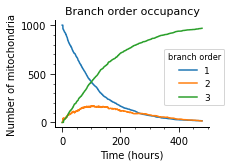

In [55]:
# Percentage occuprancy of each branch order(normalised)
fig, ax = plt.subplots()
fig.set_size_inches(7*cm, 5*cm)

ax.plot(tarray,BOnumbermitos_array)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Number of mitochondria")
fig.legend(('1','2','3'), title='branch order', loc=7, bbox_to_anchor=(1.00, 0.48), prop={'size': 9})
ax.minorticks_on()

ax.set_title('Branch order occupancy')

modplot.set_axes_properties(ax)

### Number of mitochondria at endpoints

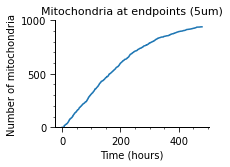

In [56]:
# Number of mitohcondria at the the 4 endpoints combined - stretch opf 5um
fig, ax = plt.subplots()
fig.set_size_inches(7*cm, 5*cm)

ax.plot(tarray,numbermitosEP_5um)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Number of mitochondria") # all endpoints combine
ax.set_ylim(0,runs)
ax.minorticks_on()
ax.tick_params(axis='y', which='minor', bottom=False)

ax.set_title('Mitochondria at endpoints (5um)') 

modplot.set_axes_properties(ax)


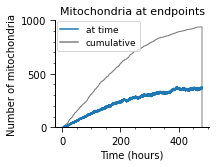

In [57]:
# Number of mitohcondria at the the 4 endpoints combined 
fig, ax = plt.subplots()
fig.set_size_inches(7*cm, 5*cm)

line, = ax.plot(tarray,numbermitosEP, label = 'at sepecified time')
hist, bns, patches = ax.hist(lat_endpoints_hours, 4000, density=False, histtype='step',
                           cumulative=True, color = 'grey', label='cumulative')
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Number of mitochondria") # all endpoints combine
ax.set_ylim(0,runs)
ax.minorticks_on()
ax.tick_params(axis='y', which='minor', bottom=False)
ax.set_title('Mitochondria at endpoints')


handles = [line, plt.Line2D([0], [0], color='grey', linestyle='-')]
labels = ['at time', 'cumulative']
ax.legend(handles, labels,loc=4, bbox_to_anchor=(0.58, 0.67), prop={'size': 9})


modplot.set_axes_properties(ax)

### Histogams number mitos vs distance

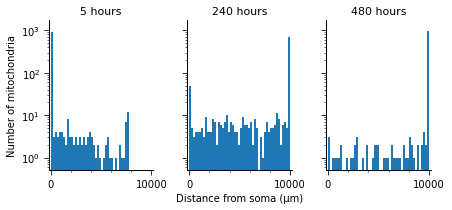

In [58]:
bins = np.arange(0, 10200, 200)


xmin = np.trunc(min(distfromsoma.values()))
xmax = int(max(distfromsoma.values()))
ymax = runs

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.5*cm,8*cm))

fig.subplots_adjust(wspace=0.05) # reduce spacing between subplots
hist1, bns1, _ = ax1.hist(XSoma[:,tpi[0]], bins= bins)
hist2, bns2, _ = ax2.hist(XSoma[:,tpi[1]], bins= bins)
hist3, bns3, _ = ax3.hist(XSoma[:,tpi[2]], bins= bins)


for i in (ax1,ax2,ax3):
    i.set_xlabel("Distance from soma (µm)")
    i.set_xlim(-200, xmax+200)
    #i.set_ylim(0, ymax+50)
    i.set_ylim((10**-0.3,12**3) )
    i.minorticks_on()


    
ax1.set_ylabel("Number of mitochondria")
ax2.set(ylabel = None)
ax3.set(ylabel = None)
ax2.tick_params(axis='y',labelleft=False)
ax3.tick_params(axis='y',labelleft=False)

ax1.set(xlabel = None)
ax3.set(xlabel = None)
    

#ax1.set_title('t = 1 minute', fontsize = 15.0,  pad=20)
#ax2.set_title('t = 24 hours', fontsize = 15.0,  pad=20)
#ax3.set_title('t = 48 hours', fontsize = 15.0,  pad=20)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

ax1.set_title('5 hours')
ax2.set_title('240 hours')
ax3.set_title('480 hours')

modplot.set_axes_properties(ax1)
modplot.set_axes_properties(ax2)
modplot.set_axes_properties(ax3)

fig.tight_layout()


### Axon backbone distribution

In [59]:
simple_G = simplifyGraph(Axon._G)

simple_xy = {}
for i in simple_G.nodes():
    simple_xy[i] = np.array(xycoordinates[i])


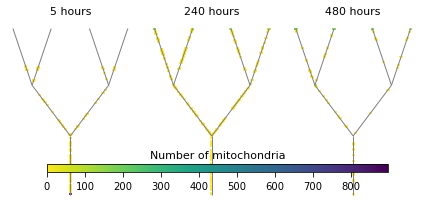

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15.5*cm,8*cm))

plt.subplots_adjust(wspace=0.1)

'''
low =  min(min(numbermitos_binned_tpi[tpi[0]].values()),min(numbermitos_binned_tpi_no0[tpi[1]].values()),min(numbermitos_binned_tpi_no0[tpi[2]].values()))
high = max(max(numbermitos_binned_tpi_no0[tpi[0]].values()),max(numbermitos_binned_tpi_no0[tpi[1]].values()),max(numbermitos_binned_tpi_no0[tpi[2]].values()))
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.autumn_r)
'''

low =  0
high = max(max(numbermitos_binned_tpi_no0[tpi[0]].values()),max(numbermitos_binned_tpi_no0[tpi[1]].values()),max(numbermitos_binned_tpi_no0[tpi[2]].values()))
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis_r)


ax1.scatter([xycoordinates[j][0] for j in numbermitos_binned_tpi_no0[tpi[0]]], [xycoordinates[j][1] for j in numbermitos_binned_tpi_no0[tpi[0]]],  s=10, marker='_', c = [mapper.to_rgba(i) for i in numbermitos_binned_tpi_no0[tpi[0]].values()])
ax2.scatter([xycoordinates[j][0] for j in numbermitos_binned_tpi_no0[tpi[1]]], [xycoordinates[j][1] for j in numbermitos_binned_tpi_no0[tpi[1]]],  s=10, marker='_', c = [mapper.to_rgba(i) for i in numbermitos_binned_tpi_no0[tpi[1]].values()])
ax3.scatter([xycoordinates[j][0] for j in numbermitos_binned_tpi_no0[tpi[2]]], [xycoordinates[j][1] for j in numbermitos_binned_tpi_no0[tpi[2]]], s=10, marker='_', c = [mapper.to_rgba(i) for i in numbermitos_binned_tpi_no0[tpi[2]].values()])


for axis in (ax1,ax2,ax3):
    nx.draw(simple_G, pos=simple_xy, node_size=0.001, node_color="grey", edge_color="grey", width=1, arrows=None, ax=axis)

ax1.set_title('5 hours')
ax2.set_title('240 hours')
ax3.set_title('480 hours')


cbar = fig.colorbar(mapper, ax = (ax1, ax2, ax3),orientation='horizontal', aspect=40)
cbar.ax.tick_params(labelsize=10, size=5)  
cbar.ax.set_title('Number of mitochondria', fontsize=11)


modplot.set_axes_properties(ax1)
modplot.set_axes_properties(ax2)
modplot.set_axes_properties(ax3)

fig.tight_layout()



### Run time to reach end once moving 

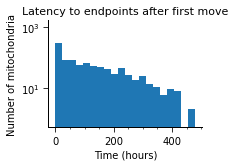

In [61]:
#log scale 
bins = np.arange(0,494,24)

fig, ax = plt.subplots()
fig.set_size_inches(7*cm, 5*cm)

ax.hist(runtimesresults,bins)
ax.set_yscale('log')
ax.set_ylim((10**-0.3,12**3) )

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Number of mitochondria")
ax.set_title("Latency to endpoints after first move")
ax.minorticks_on()


modplot.set_axes_properties(ax)


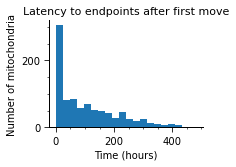

In [62]:
#normal scale
bins = np.arange(0,494,24)

fig, ax = plt.subplots()
fig.set_size_inches(7*cm, 5*cm)

hist, bns , _ = ax.hist(runtimesresults,bins)

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Number of mitochondria")
ax.set_title("Latency to endpoints after first move")
ax.minorticks_on()
#ax.set_ylim((0,280) )



modplot.set_axes_properties(ax)


### Degradation posthoc

In [ ]:
#Number of mitochondira at endpoints specifically 
numbermitosEPDeg10 = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg10, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEPDeg120 = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg120, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEPDeg240 = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg240, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEPDeg360 = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg360, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEPDeg480 = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg480, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEPDeg600 = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg600, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEPDeg720 = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg720, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEPDeg840 = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg840, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEPDeg960 = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg960, pos_list=EP, dist_dict=None, interval=None) # specific endpoints

In [ ]:
#Numebr of mitochondria ay 5um stretch of endpoints 

node_EP_range = int(5/internode) #number of nodes to make 5um 

EP_5um_nested = []
for i in EP:
    EP_5um_nested.append(list(i - np.array(range(node_EP_range))))

EP_5um = [item for sublist in EP_5um_nested for item in sublist] # flatten list

numbermitosEPDeg10_5um = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg10, pos_list=EP_5um, dist_dict=None, interval=None) 
numbermitosEPDeg120_5um = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg120, pos_list=EP_5um, dist_dict=None, interval=None) 
numbermitosEPDeg240_5um = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg240, pos_list=EP_5um, dist_dict=None, interval=None) 
numbermitosEPDeg360_5um = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg360, pos_list=EP_5um, dist_dict=None, interval=None) 
numbermitosEPDeg480_5um = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg480, pos_list=EP_5um, dist_dict=None, interval=None) 
numbermitosEPDeg600_5um = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg600, pos_list=EP_5um, dist_dict=None, interval=None) 
numbermitosEPDeg720_5um = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg720, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEPDeg840_5um = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg840, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEPDeg960_5um = modout.count_mitos_spec(numtimesteps_post, N, XresultDeg960, pos_list=EP_5um, dist_dict=None, interval=None)


In [ ]:
# Number of mitohcondria at the the 4 endpoints combined - stretch opf 5um
fig, ax = plt.subplots()
fig.set_size_inches(7*cm, 5*cm)

ax.plot(tarray,numbermitosEP_5um)
ax.plot(tarray,numbermitosEPDeg960_5um)
ax.plot(tarray,numbermitosEPDeg840_5um)
ax.plot(tarray,numbermitosEPDeg720_5um)
ax.plot(tarray,numbermitosEPDeg600_5um)
ax.plot(tarray,numbermitosEPDeg480_5um)
ax.plot(tarray,numbermitosEPDeg360_5um)
ax.plot(tarray,numbermitosEPDeg240_5um)
ax.plot(tarray,numbermitosEPDeg120_5um)
ax.plot(tarray,numbermitosEPDeg10_5um)


ax.set_xlabel("Time (hours)")
ax.set_ylabel("Number of mitochondria") # all endpoints combine
ax.set_ylim(0,runs)
ax.minorticks_on()
ax.tick_params(axis='y', which='minor', bottom=False)

ax.set_title('Mitochondria at endpoints (5um)') 

ax.legend(('None','960','840','720', '600', '480', '360', '240', '120', '10'), title='Degradation mean (h)', bbox_to_anchor=(1.15, 1.25),prop={'size': 9})#, bbox_to_anchor=(0.9, 0.5))


modplot.set_axes_properties(ax)
plt.tick_params(bottom = False) 



In [ ]:
## FOR POSITIONAL DISTOGRAMS 
XSoma = modout.convert_vector(Xresult,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSomaDeg960 = modout.convert_vector(XresultDeg960,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSomaDeg840 = modout.convert_vector(XresultDeg840,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSomaDeg720 = modout.convert_vector(XresultDeg720,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSomaDeg600 = modout.convert_vector(XresultDeg600,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSomaDeg480 = modout.convert_vector(XresultDeg480,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSomaDeg360 = modout.convert_vector(XresultDeg360,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSomaDeg240 = modout.convert_vector(XresultDeg240,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSomaDeg120 = modout.convert_vector(XresultDeg120,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSomaDeg10 = modout.convert_vector(XresultDeg10,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 

In [ ]:
##FOR TREES
countmitos_none_last = modout.count_mitos(Xresult,  N, numtimesteps_post, [numtimesteps_post-1])
countmitos_960_last = modout.count_mitos(XresultDeg960,  N, numtimesteps_post, [numtimesteps_post-1])
countmitos_480_last = modout.count_mitos(XresultDeg480,  N, numtimesteps_post, [numtimesteps_post-1])
countmitos_120_last = modout.count_mitos(XresultDeg120,  N, numtimesteps_post, [numtimesteps_post-1])
countmitos_10_last = modout.count_mitos(XresultDeg10,  N, numtimesteps_post, [numtimesteps_post-1])


numbermitos_none_last_binned = bin_tree_graph_density_3(countmitos_none_last, [numtimesteps_post-1], segments_list, 0.2, 1)
numbermitos_960_last_binned = bin_tree_graph_density_3(countmitos_960_last, [numtimesteps_post-1], segments_list, 0.2, 1)
numbermitos_480_last_binned = bin_tree_graph_density_3(countmitos_480_last, [numtimesteps_post-1], segments_list, 0.2, 1)
numbermitos_120_last_binned = bin_tree_graph_density_3(countmitos_120_last, [numtimesteps_post-1], segments_list, 0.2, 1)
numbermitos_10_last_binned = bin_tree_graph_density_3(countmitos_10_last, [numtimesteps_post-1], segments_list, 0.2, 1)

numbermitos_none_last_binned_no0 = modout.nested_dict_no0(numbermitos_none_last_binned)
numbermitos_960_last_binned_no0 = modout.nested_dict_no0(numbermitos_960_last_binned)
numbermitos_480_last_binned_no0 = modout.nested_dict_no0(numbermitos_480_last_binned)
numbermitos_120_last_binned_no0 = modout.nested_dict_no0(numbermitos_120_last_binned)
numbermitos_10_last_binned_no0 = modout.nested_dict_no0(numbermitos_10_last_binned)



In [ ]:
bins = np.arange(-1, 10200, 200)

xmin = np.trunc(min(distfromsoma.values()))
xmax = int(max(distfromsoma.values()))
ymax = runs

fig, (axs) = plt.subplots(nrows=2, ncols=3, figsize=(16.5*cm,15.2*cm))


ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[0, 2]
ax4 = axs[1, 0]
ax5 = axs[1, 1]
ax6 = axs[1, 2]

ax1.hist(XSoma[:,numtimesteps_post-1], bins= bins)
ax2.hist(XSomaDeg960[:,numtimesteps_post-1], bins= bins)
ax3.hist(XSomaDeg480[:,numtimesteps_post-1], bins= bins)
ax4.hist(XSomaDeg240[:,numtimesteps_post-1], bins= bins)
ax5.hist(XSomaDeg120[:,numtimesteps_post-1], bins= bins)
ax6.hist(XSomaDeg10[:,numtimesteps_post-1], bins= bins)


for i in (ax1,ax2,ax3,ax4, ax5, ax6):
    i.set_xlabel("Distance from soma (µm)")
    i.set_xlim(-200, xmax+200)
    #i.set_ylim(0, ymax+50)
    i.set_ylim((10**-0.3,12**3) )
    i.minorticks_on()


    
ax1.set_ylabel("Number of mitochondria")
ax4.set_ylabel("Number of mitochondria")

ax2.set(ylabel = None)
ax3.set(ylabel = None)
ax5.set(ylabel = None)
ax6.set(ylabel = None)

ax2.tick_params(axis='y',labelleft=False)
ax3.tick_params(axis='y',labelleft=False)
ax5.tick_params(axis='y',labelleft=False)
ax6.tick_params(axis='y',labelleft=False)

ax1.set(xlabel = None)
ax2.set(xlabel = None)
ax3.set(xlabel = None)
ax4.set(xlabel = None)
ax6.set(xlabel = None)

#ax1.set_title('t = 1 minute', fontsize = 15.0,  pad=20)
#ax2.set_title('t = 24 hours', fontsize = 15.0,  pad=20)
#ax3.set_title('t = 48 hours', fontsize = 15.0,  pad=20)

for i in (ax1,ax2,ax3,ax4, ax5, ax6):
    i.set_yscale('log')


ax1.set_title('No degradation')
ax2.set_title('Deg. mean = 960h')
ax3.set_title('Deg. mean = 480h')
ax4.set_title('Deg. mean = 240h')
ax5.set_title('Deg. mean = 120h')
ax6.set_title('Deg. mean = 10h')

for i in (ax1,ax2,ax3,ax4, ax5, ax6):
    modplot.set_axes_properties(i)

fig.suptitle('Spatial distribution at last timepoint (480h)',fontsize=11)

fig.tight_layout()


## k variations post hoc 

In [ ]:
numbermitosEP_k03 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk03, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEP_k10 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk10, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEP_k20 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk20, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEP_k30 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk30, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEP_k40 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk40, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEP_k50 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk50, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEP_k60 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk60, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEP_k70 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk70, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEP_k80 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk80, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEP_k90 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk90, pos_list=EP, dist_dict=None, interval=None) # specific endpoints
numbermitosEP_k97 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk97, pos_list=EP, dist_dict=None, interval=None) # specific endpoints


lat_endpoints_k03 = modout.latency_endpoint(Xresultk03, EP)
lat_endpoints_hours_k03 = lat_endpoints_k03*snapshot_num/3600
lat_endpoints_k10 = modout.latency_endpoint(Xresultk10, EP)
lat_endpoints_hours_k10 = lat_endpoints_k10*snapshot_num/3600
lat_endpoints_k20 = modout.latency_endpoint(Xresultk20, EP)
lat_endpoints_hours_k20 = lat_endpoints_k20*snapshot_num/3600
lat_endpoints_k30 = modout.latency_endpoint(Xresultk30, EP)
lat_endpoints_hours_k30 = lat_endpoints_k30*snapshot_num/3600
lat_endpoints_k40 = modout.latency_endpoint(Xresultk40, EP)
lat_endpoints_hours_k40 = lat_endpoints_k40*snapshot_num/3600
lat_endpoints_k50 = modout.latency_endpoint(Xresultk50, EP)
lat_endpoints_hours_k50 = lat_endpoints_k50*snapshot_num/3600
lat_endpoints_k60 = modout.latency_endpoint(Xresultk60, EP)
lat_endpoints_hours_k60 = lat_endpoints_k60*snapshot_num/3600
lat_endpoints_k70 = modout.latency_endpoint(Xresultk70, EP)
lat_endpoints_hours_k70 = lat_endpoints_k70*snapshot_num/3600
lat_endpoints_k80 = modout.latency_endpoint(Xresultk80, EP)
lat_endpoints_hours_k80 = lat_endpoints_k80*snapshot_num/3600
lat_endpoints_k90 = modout.latency_endpoint(Xresultk90, EP)
lat_endpoints_hours_k90 = lat_endpoints_k90*snapshot_num/3600
lat_endpoints_k97 = modout.latency_endpoint(Xresultk97, EP)
lat_endpoints_hours_k97 = lat_endpoints_k97*snapshot_num/3600


In [ ]:
node_EP_range = int(5/internode) #number of nodes to make 5um 

EP_5um_nested = []
for i in EP:
    EP_5um_nested.append(list(i - np.array(range(node_EP_range))))

EP_5um = [item for sublist in EP_5um_nested for item in sublist] # flatten list

numbermitosEP_5um_k03 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk03, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEP_5um_k10 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk10, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEP_5um_k20 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk20, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEP_5um_k30 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk30, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEP_5um_k40 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk40, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEP_5um_k50 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk50, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEP_5um_k60 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk60, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEP_5um_k70 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk70, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEP_5um_k80 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk80, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEP_5um_k90 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk90, pos_list=EP_5um, dist_dict=None, interval=None)
numbermitosEP_5um_k97 = modout.count_mitos_spec(numtimesteps_post, N, Xresultk97, pos_list=EP_5um, dist_dict=None, interval=None)




In [ ]:
karray = [0.03, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.97]
numbermitosEP_5um_lasttp_ks = [numbermitosEP_5um_k03[numtimesteps_post-1], numbermitosEP_5um_k10[numtimesteps_post-1],numbermitosEP_5um_k20[numtimesteps_post-1],
                              numbermitosEP_5um_k30[numtimesteps_post-1],numbermitosEP_5um_k40[numtimesteps_post-1], numbermitosEP_5um_k50[numtimesteps_post-1],
                              numbermitosEP_5um_k60[numtimesteps_post-1],numbermitosEP_5um_k70[numtimesteps_post-1], numbermitosEP_5um_k80[numtimesteps_post-1],
                              numbermitosEP_5um_k90[numtimesteps_post-1], numbermitosEP_5um_k97[numtimesteps_post-1]]

numbermitosEP_5um_midtp_ks = [numbermitosEP_5um_k03[numtimesteps_post//2], numbermitosEP_5um_k10[numtimesteps_post//2],numbermitosEP_5um_k20[numtimesteps_post//2],
                              numbermitosEP_5um_k30[numtimesteps_post//2],numbermitosEP_5um_k40[numtimesteps_post//2], numbermitosEP_5um_k50[numtimesteps_post//2],
                              numbermitosEP_5um_k60[numtimesteps_post//2],numbermitosEP_5um_k70[numtimesteps_post//2], numbermitosEP_5um_k80[numtimesteps_post//2],
                              numbermitosEP_5um_k90[numtimesteps_post//2], numbermitosEP_5um_k97[numtimesteps_post//2]]

numbermitosEP_5um_quarttp_ks = [numbermitosEP_5um_k03[numtimesteps_post//4], numbermitosEP_5um_k10[numtimesteps_post//4],numbermitosEP_5um_k20[numtimesteps_post//4],
                              numbermitosEP_5um_k30[numtimesteps_post//4],numbermitosEP_5um_k40[numtimesteps_post//4], numbermitosEP_5um_k50[numtimesteps_post//4],
                              numbermitosEP_5um_k60[numtimesteps_post//4],numbermitosEP_5um_k70[numtimesteps_post//4], numbermitosEP_5um_k80[numtimesteps_post//4],
                              numbermitosEP_5um_k90[numtimesteps_post//4], numbermitosEP_5um_k97[numtimesteps_post//4]]

numbermitosEP_5um_uquarttp_ks = [numbermitosEP_5um_k03[int(numtimesteps_post//1.25)], numbermitosEP_5um_k10[int(numtimesteps_post//1.25)],numbermitosEP_5um_k20[int(numtimesteps_post//1.25)],
                              numbermitosEP_5um_k30[int(numtimesteps_post//1.25)],numbermitosEP_5um_k40[int(numtimesteps_post//1.25)], numbermitosEP_5um_k50[int(numtimesteps_post//1.25)],
                              numbermitosEP_5um_k60[int(numtimesteps_post//1.25)],numbermitosEP_5um_k70[int(numtimesteps_post//1.25)], numbermitosEP_5um_k80[int(numtimesteps_post//1.25)],
                              numbermitosEP_5um_k90[int(numtimesteps_post//1.25)], numbermitosEP_5um_k97[int(numtimesteps_post//1.25)]]

In [ ]:
runtimesresults_k03 = (runtimes(Xresultk03))*snapshot_num/3600
runtimesresults_k10 = (runtimes(Xresultk10))*snapshot_num/3600
runtimesresults_k20 = (runtimes(Xresultk20))*snapshot_num/3600
runtimesresults_k30 = (runtimes(Xresultk30))*snapshot_num/3600
runtimesresults_k40 = (runtimes(Xresultk40))*snapshot_num/3600
runtimesresults_k50 = (runtimes(Xresultk50))*snapshot_num/3600
runtimesresults_k60 = (runtimes(Xresultk60))*snapshot_num/3600
runtimesresults_k70 = (runtimes(Xresultk70))*snapshot_num/3600
runtimesresults_k80 = (runtimes(Xresultk80))*snapshot_num/3600
runtimesresults_k90 = (runtimes(Xresultk90))*snapshot_num/3600
runtimesresults_k97 = (runtimes(Xresultk97))*snapshot_num/3600



In [ ]:
XSoma_k03 = modout.convert_vector(Xresultk03,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSoma_k10 = modout.convert_vector(Xresultk10,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSoma_k20 = modout.convert_vector(Xresultk20,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSoma_k30 = modout.convert_vector(Xresultk30,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSoma_k40 = modout.convert_vector(Xresultk40,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSoma_k50 = modout.convert_vector(Xresultk50,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSoma_k60 = modout.convert_vector(Xresultk60,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSoma_k70 = modout.convert_vector(Xresultk70,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSoma_k80 = modout.convert_vector(Xresultk80,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSoma_k90 = modout.convert_vector(Xresultk90,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 
XSoma_k97 = modout.convert_vector(Xresultk97,distfromsoma, numtimesteps_post, runs) # chnage X position node id to distqnce from soma at each timepoint 


In [ ]:
# Furthest distance reached by mitos 
furthest_k03 = np.empty(len(XSoma_k03))
furthest_k10 = np.empty(len(XSoma_k10))
furthest_k20 = np.empty(len(XSoma_k20))
furthest_k30 = np.empty(len(XSoma_k30))
furthest_k40 = np.empty(len(XSoma_k40))
furthest_k50 = np.empty(len(XSoma_k50))
furthest_k60 = np.empty(len(XSoma_k60))
furthest_k70 = np.empty(len(XSoma_k70))
furthest_k80 = np.empty(len(XSoma_k80))
furthest_k90 = np.empty(len(XSoma_k90))
furthest_k97 = np.empty(len(XSoma_k97))


for r in range(len(XSoma_k10)):
    furthest_k03[r] = max(XSoma_k03[r])
    furthest_k10[r] = max(XSoma_k10[r])
    furthest_k20[r] = max(XSoma_k20[r])
    furthest_k30[r] = max(XSoma_k30[r])
    furthest_k40[r] = max(XSoma_k40[r])
    furthest_k50[r] = max(XSoma_k50[r])
    furthest_k60[r] = max(XSoma_k60[r])
    furthest_k70[r] = max(XSoma_k70[r])
    furthest_k80[r] = max(XSoma_k80[r])
    furthest_k90[r] = max(XSoma_k90[r])
    furthest_k97[r] = max(XSoma_k97[r])



In [ ]:
# Number of mitohcondria at endpoints 

fig, (axs) = plt.subplots(nrows=2, ncols=3, figsize=(16*cm,10*cm), constrained_layout=True)


ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[0, 2]
ax4 = axs[1, 0]
ax5 = axs[1, 1]


line, = ax1.plot(tarray,numbermitosEP_k03, label = 'at sepecified time')
line2, = ax1.plot(tarray,numbermitosEP_5um_k03, '--', label = 'at sepecified time', linewidth=1)
hist1, _, _ = ax1.hist(lat_endpoints_hours_k03, 2000, density=False, histtype='step',
                           cumulative=True, color = 'grey', label='cumulative',linewidth=2)


line, = ax2.plot(tarray,numbermitosEP_k10, label = 'at sepecified time')
line2, = ax2.plot(tarray,numbermitosEP_5um_k10,  '--', label = 'at sepecified time,5um', linewidth=1.5)
hist2, _, _ = ax2.hist(lat_endpoints_hours_k10, 2000, density=False, histtype='step',
                           cumulative=True, color = 'grey', label='cumulative',linewidth=2)

line, = ax3.plot(tarray,numbermitosEP_k20, label = 'at sepecified time')
line2, = ax3.plot(tarray,numbermitosEP_5um_k20, '--', label = 'at sepecified time', linewidth=1.5)
hist3, _, _ = ax3.hist(lat_endpoints_hours_k20, 2000, density=False, histtype='step',
                           cumulative=True, color = 'grey', label='cumulative',linewidth=2)

line, = ax4.plot(tarray,numbermitosEP_k30, label = 'at sepecified time')
line2, = ax4.plot(tarray,numbermitosEP_5um_k30, '--', label = 'at sepecified time', linewidth=1.5)
hist4, _, _ = ax4.hist(lat_endpoints_hours_k30, 2000, density=False, histtype='step',
                           cumulative=True, color = 'grey', label='cumulative',linewidth=2)

line, = ax5.plot(tarray,numbermitosEP_k40, label = 'at sepecified time')
line2, = ax5.plot(tarray,numbermitosEP_5um_k40, '--', label = 'at sepecified time', linewidth=1.5)
hist5, _, _ = ax5.hist(lat_endpoints_hours_k40, 2000, density=False, histtype='step',
                           cumulative=True, color = 'grey', label='cumulative',linewidth=2)


ax1.set_title('k=0.03')
ax2.set_title('k=0.10')
ax3.set_title('k=0.20')
ax4.set_title('k=0.30')
ax5.set_title('k=0.40')


for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.set_ylim(0,runs)
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', bottom=False)

    

ax5.set_xlabel("Time (hours)")
ax4.set_xlabel("Time (hours)")


ax1.set_ylabel("Number of mitochondria")
#ax3.set_ylabel("Number of mitochondria")
#ax5.set_ylabel("Number of mitochondria")

#ax.set_title('Mitochondria at endpoints')
#ax.set_ylabel("Number of mitochondria") # all endpoints combine


#handles = [line, line2, plt.Line2D([0], [0], color='grey', linestyle='-')]
#labels = ['at time', 'at time, 5µm stretch','cumulative']
#ax5.legend(handles, labels,loc=5, bbox_to_anchor=(3.58, 0.67), prop={'size': 9})

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    modplot.set_axes_properties(ax)
    
fig.suptitle("Mitochondria at endpoints", fontsize=12)

    
#fig.tight_layout()



In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(7*cm, 5*cm)



ax.scatter(karray, numbermitosEP_5um_quarttp_ks, c= 'lavender', s=30, label=' at 120h')
ax.scatter(karray, numbermitosEP_5um_midtp_ks, c ='skyblue' , s=30,  label='at 240h')
ax.scatter(karray,numbermitosEP_5um_uquarttp_ks, c='tab:blue', s=30, label='at 360h')
ax.scatter(karray, numbermitosEP_5um_lasttp_ks, c='midnightblue', s=30, label='at 480h')

ax.set_xlabel("k")
ax.set_ylabel("Number of mitochondria") # all endpoints combine
ax.set_ylim(-50,runs)
ax.minorticks_on()

ax.set_title('Mitochondria at endpoints (5µm)') 

ax.legend(prop={'size': 9})

modplot.set_axes_properties(ax)



In [ ]:
bins = np.arange(0,494,24)

fig, (axs) = plt.subplots(nrows=2, ncols=3, figsize=(16*cm,10*cm), constrained_layout=True)


ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[0, 2]
ax4 = axs[1, 0]
ax5 = axs[1, 1]



hist1, _, _=ax1.hist(runtimesresults_k03,bins)
hist2, _, _=ax2.hist(runtimesresults_k10,bins)
hist3, _, _=ax3.hist(runtimesresults_k20,bins)
hist4, _, _=ax4.hist(runtimesresults_k30,bins)
hist5, _, _=ax5.hist(runtimesresults_k40,bins)

ax1.set_title('k=0.03')
ax2.set_title('k=0.10')
ax3.set_title('k=0.20')
ax4.set_title('k=0.30')
ax5.set_title('k=0.40')



for ax in (ax1,ax2,ax3,ax4,ax5):
    ax.minorticks_on()
    ax.set_ylim(0,300)
    ax.set_xlim(0,480)

    modplot.set_axes_properties(ax)



ax5.set_xlabel("Time (hours)")
ax4.set_xlabel("Time (hours)")

ax1.set_ylabel("Number of mitochondria")
#ax3.set_ylabel("Number of mitochondria")
#ax5.set_ylabel("Number of mitochondria")

fig.suptitle("Latency to endpoint after first move", fontsize=12)

fig.tight_layout()



In [ ]:
# To work out the percentage that teh first bar represents
hist5 / sum(runtimesresults_k40>=0) * 100


In [ ]:
bins = np.arange(0,480,24)


fig, (axs) = plt.subplots(nrows=2, ncols=3, figsize=(16*cm,10*cm), constrained_layout=True)


ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[0, 2]
ax4 = axs[1, 0]
ax5 = axs[1, 1]


hist1, _, _ = ax1.hist(runtimesresults_k03,bins,density=True)
hist2, _, _ = ax2.hist(runtimesresults_k10,bins,density=True)
hist3, _, _ = ax3.hist(runtimesresults_k20,bins,density=True)
hist4, _, _ = ax4.hist(runtimesresults_k30,bins,density=True)
hist5, _, _ = ax5.hist(runtimesresults_k40,bins,density=True)

ax1.set_title('k=0.03')
ax2.set_title('k=0.10')
ax3.set_title('k=0.20')
ax4.set_title('k=0.30')
ax5.set_title('k=0.40')



for ax in (ax1,ax2,ax3,ax4,ax5):
    ax.minorticks_on()
    #ax.set_ylim(0,300)
    ax.set_ylim(0,0.016)
    modplot.set_axes_properties(ax)



ax5.set_xlabel("Time (hours)")
ax4.set_xlabel("Time (hours)")

ax1.set_ylabel("Probability density (number of mitochondria)")
#ax3.set_ylabel("Fraction of mitochondria")#"Fraction of mitochondria having reached endpoint"
#ax5.set_ylabel("Fraction of mitochondria")

fig.suptitle("Latency to endpoint after first move", fontsize=12)

fig.tight_layout()



In [ ]:
hist5 / sum(runtimesresults_k40>=0) * 100


In [ ]:
##trying normalised 
bins = np.arange(0,480,24)


fig, (axs) = plt.subplots(nrows=2, ncols=3, figsize=(16*cm,10*cm), constrained_layout=True)


ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[0, 2]
ax4 = axs[1, 0]
ax5 = axs[1, 1]


hist1, _, _ = ax1.hist(runtimesresults_k03,bins,density=True)
hist2, _, _ = ax2.hist(runtimesresults_k10,bins,density=True)
hist3, _, _ = ax3.hist(runtimesresults_k20,bins,density=True)
hist4, _, _ = ax4.hist(runtimesresults_k30,bins,density=True)
hist5, _, _ = ax5.hist(runtimesresults_k40, bins, density=True)

ax1.set_title('k=0.03')
ax2.set_title('k=0.10')
ax3.set_title('k=0.20')
ax4.set_title('k=0.30')
ax5.set_title('k=0.40')



for ax in (ax1,ax2,ax3,ax4,ax5):
    ax.minorticks_on()
    #ax.set_ylim(0,300)
    ax.set_ylim(0,0.016)
    modplot.set_axes_properties(ax)



ax5.set_xlabel("Time (hours)")
ax4.set_xlabel("Time (hours)")

ax1.set_ylabel("Fraction of mitochondria")
#ax3.set_ylabel("Fraction of mitochondria")#"Fraction of mitochondria having reached endpoint"
#ax5.set_ylabel("Fraction of mitochondria")

fig.suptitle("Latency to endpoint after first move", fontsize=12)

fig.tight_layout()



In [ ]:
np.median(runtimesresults_k40[runtimesresults_k40>=0])

In [ ]:
bins = np.arange(0, 10200, 200)



xmin = np.trunc(min(distfromsoma.values()))
xmax = int(max(distfromsoma.values()))
ymax = runs


fig, (axs) = plt.subplots(nrows=2, ncols=3, figsize=(16*cm,15.5*cm), constrained_layout=True)


ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[0, 2]
ax4 = axs[1, 0]
ax5 = axs[1, 1]
ax6 = axs[1, 2]

fig.subplots_adjust(wspace=0.05) # reduce spacing between subplots
hist1, _, _ = ax1.hist(XSoma_k03[:,[numtimesteps_post-1]], bins= bins)
hist2, _, _ = ax2.hist(XSoma_k10[:,[numtimesteps_post-1]], bins= bins)
hist3, _, _ = ax3.hist(XSoma_k20[:,[numtimesteps_post-1]], bins= bins)
hist4, _, _ = ax4.hist(XSoma_k30[:,[numtimesteps_post-1]], bins= bins)
hist5, _, _ = ax5.hist(XSoma_k40[:,[numtimesteps_post-1]], bins= bins)
hist6, _, _ = ax6.hist(XSoma_k50[:,[numtimesteps_post-1]], bins= bins)

ax1.set_title('k=0.03')
ax2.set_title('k=0.10')
ax3.set_title('k=0.20')
ax4.set_title('k=0.30')
ax5.set_title('k=0.40')
ax6.set_title('k=0.50')

for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.set_yscale('log')
    ax.set_xlim(-400, xmax+400)
    #i.set_ylim(0, 900)
    ax.set_ylim((10**-0.2,12**3) )
    ax.minorticks_on()
    modplot.set_axes_properties(ax)



    
ax1.set_ylabel("Number of mitochondria")
ax4.set_ylabel("Number of mitochondria")
ax5.set_xlabel("Distance from soma (µm)")

#ax2.tick_params(axis='y',labelleft=False)
#ax3.tick_params(axis='y',labelleft=False)

#ax1.set(xlabel = None)
#ax3.set(xlabel = None)
    

#ax1.set_title('t = 1 minute', fontsize = 15.0,  pad=20)
#ax2.set_title('t = 24 hours', fontsize = 15.0,  pad=20)
#ax3.set_title('t = 48 hours', fontsize = 15.0,  pad=20)

fig.suptitle("Mitochondial distribution at last timepoint (480h)", fontsize=12)



fig.tight_layout()


In [ ]:
bins = np.arange(0, 10200, 200)



xmin = np.trunc(min(distfromsoma.values()))
xmax = int(max(distfromsoma.values()))


fig, (axs) = plt.subplots(nrows=2, ncols=3, figsize=(16*cm,15.5*cm), constrained_layout=True)


ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[0, 2]
ax4 = axs[1, 0]
ax5 = axs[1, 1]
ax6 = axs[1, 2]

fig.subplots_adjust(wspace=0.05) # reduce spacing between subplots
hist1, _, _ = ax1.hist(XSoma_k03[:,[numtimesteps_post-1]], bins= bins)
hist2, _, _ = ax2.hist(XSoma_k10[:,[numtimesteps_post-1]], bins= bins)
hist3, _, _ = ax3.hist(XSoma_k20[:,[numtimesteps_post-1]], bins= bins)
hist4, _, _ = ax4.hist(XSoma_k30[:,[numtimesteps_post-1]], bins= bins)
hist5, _, _ = ax5.hist(XSoma_k40[:,[numtimesteps_post-1]], bins= bins)
hist6, _, _ = ax6.hist(XSoma_k50[:,[numtimesteps_post-1]], bins= bins)

ax1.set_title('k=0.03')
ax2.set_title('k=0.10')
ax3.set_title('k=0.20')
ax4.set_title('k=0.30')
ax5.set_title('k=0.40')
ax6.set_title('k=0.50')

for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    #ax.set_yscale('log')
    ax.set_xlim(-400, xmax+400)
    ax.set_ylim(0, 1000)
    #ax.set_ylim((10**-0.2,12**3) )
    ax.minorticks_on()
    modplot.set_axes_properties(ax)



    
ax1.set_ylabel("Number of mitochondria")
ax4.set_ylabel("Number of mitochondria")
ax5.set_xlabel("Distance from soma (µm)")

#ax2.tick_params(axis='y',labelleft=False)
#ax3.tick_params(axis='y',labelleft=False)

#ax1.set(xlabel = None)
#ax3.set(xlabel = None)
    

#ax1.set_title('t = 1 minute', fontsize = 15.0,  pad=20)
#ax2.set_title('t = 24 hours', fontsize = 15.0,  pad=20)
#ax3.set_title('t = 48 hours', fontsize = 15.0,  pad=20)

fig.suptitle("Mitochondial distribution at last timepoint (480h)", fontsize=12)



fig.tight_layout()


In [ ]:
hist5>24

In [ ]:
#Furthest distance reached by mitos 


bins = np.arange(-500,10500,500)

fig, (axs) = plt.subplots(nrows=4, ncols=2, figsize=(16.5*cm,18.5*cm))


ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
ax5 = axs[2, 0]
ax6 = axs[2, 1]
ax7 = axs[3, 0]
ax8 = axs[3, 1]

hist1, _, _ = ax1.hist(furthest_k03,bins)#,density=True)
hist2, _, _ =ax2.hist(furthest_k10,bins)#,density=True)
hist3, _, _ =ax3.hist(furthest_k20,bins)#,density=True)
hist4, _, _ =ax4.hist(furthest_k30,bins)#,density=True)
hist5, _, _ =ax5.hist(furthest_k40,bins)#,density=True)
hist6, _, _ =ax6.hist(furthest_k50,bins)#,density=True)
hist7, _, _ =ax7.hist(furthest_k60,bins)#,density=True)
#ax8.hist(furthest_k70,bins)#,density=True)

ax1.set_title('k=0.03')
ax2.set_title('k=0.10')
ax3.set_title('k=0.20')
ax4.set_title('k=0.30')
ax5.set_title('k=0.40')
ax6.set_title('k=0.50')
ax7.set_title('k=0.60 / 0.70 / 0.80 / 0.90 / 0.97')



for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.minorticks_on()
    ax.set_ylim(0,1000)
    #ax.set_ylim(0,0.016)
    modplot.set_axes_properties(ax)


#ax1.set_ylabel("Number of mitochondria")
ax3.set_ylabel("Number of mitochondria")
#ax5.set_ylabel("Number of mitochondria")
ax7.set_ylabel("Number of mitochondria")

ax7.set_xlabel("Distance from soma (µm)")
ax6.set_xlabel("Distance from soma (µm)")



fig.suptitle("Distribution of furthest distance reached", fontsize=12)

fig.tight_layout()



In [ ]:
max(furthest_k50)

In [ ]:
bins = np.arange(-500,10500,500)

fig, (axs) = plt.subplots(nrows=4, ncols=2, figsize=(16.5*cm,18.5*cm))


ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
ax5 = axs[2, 0]
ax6 = axs[2, 1]
ax7 = axs[3, 0]
ax8 = axs[3, 1]

ax1.hist(furthest_k03,bins)#,density=True)
ax2.hist(furthest_k10,bins)#,density=True)
ax3.hist(furthest_k20,bins)#,density=True)
ax4.hist(furthest_k30,bins)#,density=True)
ax5.hist(furthest_k40,bins)#,density=True)
ax6.hist(furthest_k50,bins)#,density=True)
ax7.hist(furthest_k60,bins)#,density=True)
#ax8.hist(furthest_k70,bins)#,density=True)

ax1.set_title('k=0.03')
ax2.set_title('k=0.10')
ax3.set_title('k=0.20')
ax4.set_title('k=0.30')
ax5.set_title('k=0.40')
ax6.set_title('k=0.50')
ax7.set_title('k=0.60 / 0.70 / 0.80 / 0.90 / 0.97')



for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.minorticks_on()
    ax.set_yscale('log')
    #ax.set_ylim(0,1000)
    ax.set_ylim((10**-0.2,10**3) )

    modplot.set_axes_properties(ax)


#ax1.set_ylabel("Number of mitochondria")
ax3.set_ylabel("Number of mitochondria")
#ax5.set_ylabel("Number of mitochondria")
ax7.set_ylabel("Number of mitochondria")

ax7.set_xlabel("Distance from soma (µm)")
ax6.set_xlabel("Distance from soma (µm)")



fig.suptitle("Dsitribution of furthest distance reached", fontsize=12)

fig.tight_layout()

